# NTDS - Project 

In [121]:
#General
import glob
import os.path
import numpy as np
import pandas as pd
from utils import *
from os import listdir 
import matplotlib.pyplot as plt 
%matplotlib inline
from ipywidgets import IntSlider, interact

#Graph
import networkx as nx
from pygsp import graphs, learning

#Scipy
from scipy import stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

#Sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import matthews_corrcoef as mc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2

#Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Torch
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## Table of content

1. [Introduction](#intro)
2. [Data acquisition](#acquisition) <br>
    2.1 [Genotype](#genotype) <br>
    2.2 [Phenotype](#phenotype) <br>
    2.3 [Expression data](#expression) <br>
    2.4 [Others](#others) <br>
3. [Data exploration](#exploration) <br>
    3.1 [Genotype network](#genotype_net) <br>
    3.2 [Phenotype network](#phenotype_net) <br>
    3.3 [Expression data network](#expression_net) <br>
4. [Exploitation](#exploitation) <br>
    4.3 [Expression data network](#expression_network) <br>

## 1. Introduction
<a id='intro'></a>

|          | Description                                                  |         Amount |
| -------- | ------------------------------------------------------------ | -------------: |
| nodes    | mice                                                         |      100 - 200 |
| edges    | similar genes, protein expressions, or phenotypes            | O(10) per node |
| features | genes, protein expressions in tissues, or phenotypes         |          1000s |
| labels   | depends: a particular gene, phenotype, or protein expression |            N/A |

## 2. Data acquisition
<a id='acquisition'></a>

>Each column is a single BXD strain (a mouse) whose genome is a unique combination of the C57BL/6J and DBA/2J parental strains.

In [2]:
data_folder = './data/BXD data-3/'
expression_data_folder = data_folder + '/expression data/'

### 2.1 Genotype
<a id='genotype'></a>

>The ``genotype_BXD.txt`` file is a binary matrix that describes the contribution of each of the parental strains for a list of selected genes (rows). Each row of the genotype data indicates whether a certain position in the genome is inherited from the C57BL/6J or DBA/2J parent.

In [3]:
df_genotype = pd.read_csv(data_folder + 'genotype_BXD.txt', delimiter ="\t", index_col='SNP').transpose()
df_genotype.index.name = 'BDX_strain'
print(df_genotype.shape)
df_genotype.head()

(97, 7324)


SNP,rs31443144,rs6269442,rs32285189,rs258367496,rs32430919,rs36251697,rs30658298,rs51852623,rs31879829,rs36742481,...,rs47382998,rs13484107,rs3693969,DXMit223,rs31638776,rs31639754,rs46326766,rs31412493,rs31417520,UT-M-9461
BDX_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-1
D2B6F1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-1,-1,-1,1
C57BL.6J,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
DBA.2J,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BXD1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,1,-1


### 2.2 Phenotype
<a id='phenotype'></a>

>Phenotype data contained in ``Phenotype.txt`` are also matrices indicating the values of each phenotype for each strain.

In [23]:
df_phenotype = pd.read_csv(data_folder + "Phenotype.txt", delimiter="\t", index_col='PhenoID').transpose() 
df_phenotype.index.name = 'BXD_strain'
print(df_phenotype.shape)
df_phenotype.head(10)

(97, 5092)


PhenoID,X3063,X3352,X1093,X2256,X830,X1516,X2451,X3938,X1892,X908,...,X794,X1245,X2048,X502,X2307,X1827,X1149,X3873,X35,X57
BXD_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.894,NaN
D2B6F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C57BL.6J,1254.09,724.205,887.5,607.708,35444.0,26784.0,13018.0,9457.0,4764.0,2704.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.22,47.847,NaN
DBA.2J,NaN,NaN,507.4,460.070,25325.0,22411.0,2792.0,4354.0,4471.0,4114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.28,52.500,NaN
BXD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4032.0,3366.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BXD6,NaN,700.643,NaN,NaN,NaN,NaN,NaN,NaN,3046.0,2532.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.602,NaN
BXD8,NaN,1304.790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Expression data
<a id='expression'></a>

>In addition, multiomic molecular phenotypes from different mouse organs are represented as one matrix per organ (e.g., brain, bone, muscle, liver, etc.), in the ``expression_data`` folder.

In [5]:
def open_expression_data(folder, txt_file):
    expression_data = pd.read_csv(folder + txt_file + '.txt', delimiter ="\t", index_col='gene').transpose()
    expression_data.index.name = 'BXD_strain'
    
    return expression_data

In [6]:
expression_data_folder = data_folder + '/expression data/'

In [7]:
adrenal_female = open_expression_data(expression_data_folder, 'Adrenal_Female')
print(adrenal_female.shape)
adrenal_female.head()

(50, 25613)


gene,Nmt1_10338077,Psmb5_10338095,Hdac5_10338098,Dlg1_10338109,Wars_10338116,Psph_10338122,Copa_10338123,Tbl3_10338144,Gbf1_10338168,Polr2f_10338173,...,Defa-rs7_10608643,Defacr_10608653,Hjurp_10608671,Defa-rs2_10608688,rRNA_10608690,rRNA_10608691,Pdia4_10608692,Rn5s_10608693,Prkcg_10608705,Kdelr2_10608708
BXD_strain,,,,,,,,,,,,,,,,,,,,,
B6D2F1,12.032,13.556,9.238,7.332,10.890,5.092,10.124,8.632,9.258,8.277,...,8.762,8.512,9.057,7.274,14.632,14.626,11.419,8.013,7.566,11.703
C57BL.6J,11.739,13.179,8.870,8.543,10.911,6.153,9.971,8.430,9.690,8.713,...,8.730,8.388,9.538,7.270,14.838,14.777,11.119,8.505,7.552,11.564
DBA.2J,11.690,12.750,9.690,3.976,10.947,5.877,10.151,8.760,9.439,8.122,...,8.549,8.029,9.124,7.084,14.628,14.581,11.210,7.729,7.326,11.774
BXD1,11.718,12.516,9.119,7.630,10.494,5.732,10.502,8.690,9.272,8.599,...,8.750,8.259,9.326,7.246,14.698,14.599,11.386,8.397,7.683,12.343
BXD11,11.633,12.935,9.060,3.902,10.595,5.021,9.719,8.233,9.310,8.954,...,8.616,8.182,10.588,7.321,14.758,14.707,10.778,8.258,7.386,11.724


In [8]:
adrenal_male = open_expression_data(expression_data_folder, 'Adrenal_Male')
eye = open_expression_data(expression_data_folder, 'Eye')

### 2.4 Others
<a id='others'></a>

In [63]:
df_id_aligner = pd.read_csv(data_folder + 'phenotypes_id_aligner.txt', sep='\t', encoding='latin1', index_col='PhenoID')
df_id_aligner.head(1)

,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,Quantitive.trait,Tissues,Diet,Strains
PhenoID,,,,,,,,,,,,,,,,
X3063,3063,12890,"Central nervous system, metabolism, behavior: ...","Activity of 13-week old females, total counts ...",Activity,1.0,1.0,"Central nervous system, metabolism, behavior: ...","Central nervous system, metabolism, behavior: ...","Andreux P, Williams EG, Koutnikova H, Houtkoop...",Auwerx_1,Activity of 13-week old females,Yes,muscle,NaN,19


In [76]:
names = df_id_aligner.columns[4:].to_list() # just to make it fit in the available space

@interact
def show_strains_more_than(column='Strains', x=(1,97,1)):
    return df_id_aligner.loc[df_id_aligner[column] > x][names].sort_values(by='Strains', ascending=False)

interactive(children=(Text(value='Strains', description='column'), IntSlider(value=49, description='x', max=97…

In [109]:
df_map = pd.read_csv(data_folder + 'map_BXD.txt', sep ="\t")
print(df_map.shape)
df_map.head()

(7324, 3)


,SNP,Chr,Pos
0,rs31443144,1,3.010274
1,rs6269442,1,3.492195
2,rs32285189,1,3.511204
3,rs258367496,1,3.659804
4,rs32430919,1,3.777023


## 3. Data exploration
<a id='exploration'></a>

This section aims at building the different adjacency matrix for the different data. According to:

$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [133]:
def gaussian_kernel(dist, sigma):
    return np.exp(-dist**2 / (2*sigma**2))

In [134]:
def get_adjacency(X: np.ndarray, dist_metric, normalize=True, weighted=False, sigma=None):
    ''' X (n x d): coordinates of the n data points in R^d.
        dist_metric: metric used to compute the distance between nodes -> e.g. 'euclidean', 'cosine', 'jaccard'
        normalize (bool): normalize data using zscore along the 0-axis
        weighted  (bool): if we want a weighted graph using a gaussian_kernel 
        
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    '''
    N = len(X)
    if normalize:
        X = stats.zscore(X, axis=0)
         
    X_dist = squareform(pdist(X, metric=dist_metric))
    
    # Threshold using the mean distance
    threshold = np.nanmean(X_dist) #X_dist.mean()
    
    # build adjacency
    if weighted:
        if sigma is None:
            sigma = 0.6
        adjacency = gaussian_kernel(X_dist, sigma)
        adjacency -= np.identity(N)
        adjacency[X_dist >= threshold] = 0
    else:
        adjacency = X_dist.copy()
        adjacency[X_dist < threshold] = 1
        adjacency[X_dist >= threshold] = 0
        np.fill_diagonal(adjacency, 0.0)
    
    return adjacency

In [122]:
# TODO
def get_weight_matrix(X: np.ndarray, dist_metric):
    raise NotImplementedError

### 3.1 Genotype network
<a id='genotype_net'></a>

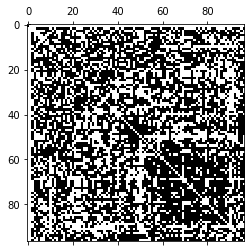

In [135]:
genotype_adjacency = get_adjacency(df_genotype.to_numpy(), 'jaccard', normalize=True)
plt.spy(genotype_adjacency, vmin=0, vmax=1)

### 3.2 Phenotype network
<a id='phenotype_net'></a>

In [29]:
# Check NaN
# Check if there is a line full of NaN
print('There are {} rows with all NaN values'.format(df_phenotype.shape[0] - df_phenotype.dropna(axis=0, how='all').shape[0]))
print('There are {} cols with all NaN values'.format(df_phenotype.shape[1] - df_phenotype.dropna(axis=1, how='all').shape[1]))

There are 0 rows with all NaN values
There are 4 cols with all NaN values


In [53]:
# list of the all NaN columns (golf coding mode)
df_phenotype.drop(columns=df_phenotype.dropna(axis=1, how='all').columns.to_list()).columns.to_list()

['X40', 'X2271', 'X1149', 'X57']

In [54]:
# Check
df_phenotype['X40'].isna().sum()

97

### 3.3 Expression data network
<a id='expression_net'></a>

In [98]:
def check_for_nan(filename):
    ''' filename: name (= string) of the file in the 'expression data' folder
        output: bool assessing for the presence or NaN or not
    '''
    df = open_expression_data(expression_data_folder, filename)
    
    if df.isna().any(axis=None):
        print('{}: NaN!, number of strains: {}'.format(filename, df.shape[0]))
    else:
        print('{}: OK!, number of strains: {}'.format(filename, df.shape[0]))

In [99]:
# check files
expression_data_files = listdir(expression_data_folder)  
expression_data_files = [filename for filename in expression_data_files if filename.endswith(".txt")] # take only .txt files

for file in expression_data_files:
    check_for_nan(os.path.splitext(file)[0]) # we don't need extension

Adrenal_Female: OK!, number of strains: 50
Adrenal_Male: OK!, number of strains: 46
Amygdala_Female: OK!, number of strains: 53
Amygdala_Male: OK!, number of strains: 56
BAT: OK!, number of strains: 37
Bone_Femur: NaN!, number of strains: 32
Brain_INIA: OK!, number of strains: 43
Brain_UTHSC: OK!, number of strains: 32
Cerebellum: OK!, number of strains: 30
Eye: OK!, number of strains: 72
Gastrointestinal: OK!, number of strains: 50
Heart_CD: OK!, number of strains: 42
Heart_HFD: OK!, number of strains: 39
Hippocampus: OK!, number of strains: 71
Hypothalamus_Female: OK!, number of strains: 43
Hypothalamus_Male: OK!, number of strains: 44
Kidney_Female: OK!, number of strains: 52
Kidney_Male: OK!, number of strains: 38
LiverProt_CD: NaN!, number of strains: 97
LiverProt_HFD: NaN!, number of strains: 97
Liver_CD: OK!, number of strains: 41
Liver_HFD: OK!, number of strains: 40
Liver_metabolite_CD: NaN!, number of strains: 97
Liver_metabolite_HFD: NaN!, number of strains: 97
Lung: OK!, nu

In [95]:
#check_for_nan('Adrenal_Female')
#check_for_nan('Adrenal_Male')
#check_for_nan('Eye')

In [80]:
# Check for NaN
#print(adrenal_female.isna().any(axis=None))
#print(adrenal_male.isna().any(axis=None))
#print(eye.isna().any(axis=None))

In [100]:
phenotypes_list = ['Adrenal_Female', 'Adrenal_Male', 'Eye', 'Hypothalamus_Female', 'Hypothalamus_Male']

In [101]:
# Visualization
def plot_matrix(phenotype=phenotypes_list):
    df = open_expression_data(expression_data_folder, phenotype)
    adj = get_adjacency(df.to_numpy(), 'euclidean', normalize=True) 
    fig = plt.spy(adj, vmin=0, vmax=1)

interact(plot_matrix, n_iter=IntSlider(min=1, max=len(phenotypes_list)))

interactive(children=(Dropdown(description='phenotype', options=('Adrenal_Female', 'Adrenal_Male', 'Eye', 'Hyp…

<function __main__.plot_matrix(phenotype=['Adrenal_Female', 'Adrenal_Male', 'Eye', 'Hypothalamus_Female', 'Hypothalamus_Male'])>

In [ ]:
# TODO: phenotype matrix

## 4. Exploitation
<a id='exploitation'></a>

Goal of this section: build networks.

### 4.3 Expression data network
<a id='expression_network'></a>

In [119]:
mouse_strains = eye.index.to_list()[3:-1]

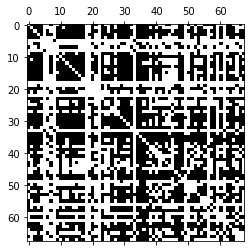

In [120]:
adj = get_adjacency(eye.loc[mouse_strains], 'euclidean', normalize=True)
plt.spy(adj, vmin=0, vmax=1)

In [124]:
graph_g = nx.from_numpy_array(adj)

In [136]:
#nx.draw_spring(graph_g, node_size=10)

## Supp

In [106]:
df_phenotype.shape[0] - df_phenotype['X3063'].isna().sum()

19

In [107]:
df_phenotype.shape[0]

97

In [108]:
df_phenotype['X3063'].isna().sum()

78

### 4.4 Custom Graph Neural Network Approach

<div class="alert alert-info">
Load data --> genotype for adjacency matrix, expressions for features nodes and phenotype "X62" as label
</div>

In [ ]:
DATA_DIR = "../../Data/"

#Phenotype
pheno = pd.read_csv(DATA_DIR+'Phenotype.txt', sep="\t", index_col="PhenoID")
pheno.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
y = pheno.loc["X62"].dropna()
y_cat = pd.get_dummies(y)

#Genotype
geno = pd.read_csv(DATA_DIR+'Genotype_BXD.txt', sep="\t", index_col=["SNP"])
genotype_df = geno.loc[:,y.index].T

#Expression
filenames = glob.glob(DATA_DIR+"expression data" + "/*.txt")
dfs = [pd.read_csv(f, sep="\t") for f in filenames]
expression = pd.concat(dfs, ignore_index=True, sort=False)
expression = expression.set_index(["gene"])
expression.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)
# keep only gene where there is less than 30 Nan // so more than 60 mice recorded.
nanByGene = expression.loc[:,y.index].isnull().sum(axis=1)
mask = nanByGene < 30
maskedEx = expression.loc[mask,y.index].T

<div class="alert alert-info">Generate Ajdacency from genotype</div>

In [ ]:
# Generate adjacency from genotype
weighted_adj = adjacency_subset(genotype_df, genotype_df.index, 'cosine')
weighted_adj = th.tensor(weighted_adj.todense())
g = graphs.Graph(weighted_adj,"normalized")

<div class="alert alert-info">Imputations methods</div>

In [ ]:
#Naive mean
maskedExMean = maskedEx.fillna(masedEx.mean(axis=0))

# Thikonov method
def tikhonov_imputation(G, meas):
    """Impute missing values to a ndarray signal of shape (G.N, # of features)"""
    assert isinstance(G, graphs.Graph)
    assert isinstance(meas, np.ndarray)
    #assert meas.shape[0] == G.n_vertices
    
    # Init
    meas_copy = np.copy(meas)    
    imputed_array = np.zeros(meas.shape)
    val_mask = ~np.isnan(meas_copy)

    for idx in range(meas.shape[1]):
        
        if (idx%10000 == 0):
            print(idx,"/",meas.shape[1])
        imputed_array[:, idx] = learning.regression_tikhonov(G, meas_copy[:, idx], val_mask[:, idx], tau=0.1)
    
    imputed_array[val_mask] = meas[val_mask]
    # Verify consistancy
    assert (meas[val_mask] == imputed_array[val_mask]).all()
    return imputed_array


maskedExTik = tikhonov_imputation(g, np.array(maskedEx))

<div class="alert alert-info">Features Selections / Generation of subsets</div>

In [ ]:
#RandomForest
clf = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
clf.fit(maskedExMean, y_cat)
top30RFind = np.argsort(clf.feature_importances_)[::-1][:30]
top30RF = maskedExMean[:,top30RFind]

#same with thikonov imputated values
clfTik = RandomForestClassifier(n_estimators=500, random_state=0, n_jobs=-1)
clfTik.fit(maskedExTik, y_cat)
top30RFind = np.argsort(clfTik.feature_importances_)[::-1][:30]
top30RFTik = maskedExTik[:,top30RFind]

In [ ]:
#Mutual Information
mi = mutual_info_classif(maskedExMean,y)
top30Ind = np.argsort(mi)[::-1][:30]
top30MI = maskedExMean[:,top30Ind]

#same with thikonov imputated values
miTik = mutual_info_classif(maskedExTik,y)
top30IndTik = np.argsort(mi)[::-1][:30]
top30MITik = maskedExTik[:,top30Ind]

In [ ]:
#Chi-squared
chi,_ = chi2(maskedExMedian,y_cat)
top30CHIind = np.argsort(chi)[::-1][:30]
top30CHI = maskedExMedian[:,top30CHIind]

#same with thikonov imputated values
chiTik,_ = chi2(maskedExMedian,y_cat)
top30CHIindTik = np.argsort(chi)[::-1][:30]
top30CHITik = maskedExMedian[:,top30CHIind]

<div class="alert alert-info">Startified Split of the data into train/test</div>

In [ ]:
labels = th.LongTensor(y_cat.values)
labels = np.argmax(labels,axis=1)

ind_0 = np.where(labels==0)[0][:12]
ind_1 = np.where(labels==1)[0][:12]
ind_2 = np.where(labels==2)[0][:12]
ind_3 = np.where(labels==3)[0][:12]

train_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
valTest_mask = [i for i in range(len(labels)) if i not in train_mask]

ind_0 = np.where(labels==0)[0][12:12+9]
ind_1 = np.where(labels==1)[0][12:12+6]
ind_2 = np.where(labels==2)[0][12:12+3]
ind_3 = np.where(labels==3)[0][12:12+4]

val_mask = [*ind_0,*ind_1,*ind_2,*ind_3]
test_mask = [i for i in valTest_mask if i not in val_mask]

<div class="alert alert-info">Graph Neural Network construction</div>

In [ ]:
class GraphLayer(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.LeakyReLU(0.6,True)):
        super(GraphLayer, self).__init__()
        fc = [nn.Linear(in_features, out_features)]
        if activation is not None:
            fc.append(activation)
        self.fc = nn.Sequential(*fc)
        
    def forward(self, A, x):
        """See randomWalk function to better understand as A was modified"""
        #Weighted average of neighbours's features.
        y = th.mm(A, x)
        
        return self.fc(y)

In [ ]:
class GNN(nn.Module):
    def __init__(self, num_feats, h1, h2, drop, num_classes):         
        super(GNN, self).__init__()
        self.gl1 = GraphLayer(num_feats,h1)
        self.gl2 = GraphLayer(h1,h2)
        self.fc3 = nn.Linear(h2, num_classes)
        self.Dropout = nn.Dropout(drop)

    def forward(self, A, x):
        x = self.Dropout(self.gl1(A,x))
        x = self.Dropout(self.gl2(A,x))
        return self.fc3(x) 

In [ ]:
def train(model, A, batchs, loss_fcn, train_mask, optimizer, n_neigh):
    model.train()  # Activate dropout
    
    losses_ = []
    real_batchs = 32
    for i in range(real_batchs):
        
        A_nn = randomWalk(A,2,n_neigh)
        
        for batch in batchs:

            features, labels = batch
            optimizer.zero_grad()
            logits = model(A_nn, features.float())
            loss = loss_fcn(logits[train_mask], labels[train_mask])
            loss.backward()
            optimizer.step()
            losses_.append(loss)
        
    return th.mean(th.stack(losses_))


def evaluate(model, A, features, labels, mask, n_neigh):
    model.eval()  # Deactivate dropout
    with th.no_grad():
        real_batchs = 32
        corrects = 0
        labels = labels[mask]
        mc_ = []
        for i in range(real_batchs):
            A_nn = randomWalk(A,2,n_neigh)
    
            logits = model(A_nn, features.float())[mask]  # only compute the evaluation set
            _, indices = th.max(logits, dim=1)
            corrects = corrects + th.sum(indices == labels)
            mc_.append(mc(labels,indices))
            
        #return Accuracy and Mcc
        return corrects.item() * 1.0 / (len(labels)*real_batchs),  np.sum(mc_)/real_batchs

In [ ]:
def randomWalk(A, max_path=4, max_n=4):
    """Not actually a randomWalk but the idea is the same;
    Take only in account "max_n" randomly chosen neighbours of degree <= "max_path",
    weighted by the edge(s) in between.
    (degree == how many step from initial node to get to neighbour)"""
    
    A_1 = A.float() + th.eye(A.shape[0])
    A_n = F.normalize(A_1, p=1, dim=1)
    A_4 = np.linalg.matrix_power(A_n,max_path)
    
    for i in range(A.shape[1]):

        ind_non_empty = np.where(A_4[i,:] > 0)[0]
        
        if len(ind_non_empty) < max_n:
            select_ind = ind_non_empty
        else:
            select_ind = list(np.random.choice(ind_non_empty,max_n))

        select_ind = np.append(select_ind,i)
        A_4[i,~select_ind] = 0

    A_4t = th.tensor(A_4)
    A_nn = F.normalize(A_4t.float(), p=1, dim=1)
        
    return A_nn

<div class="alert alert-info">Graph Neural Network Training and Evaluation </div>

In [ ]:
#Generate result for 3 varying parameters; imputation method, Feature selection method, # of neighbours

subsets_ = [[top30RF, top30MI, top30CHI],[top30RFTik, top30MITik, top30CHITik]]
names = ["median","thikonov"]
subnames = ["RF","MI","CHI2"]
max_neighbours = [1,3,5,10]
max_trials = 10

WholeResults = {}

#imputing method
for mname, methodsubset in zip(names,subsets_):
    
    WholeResults[mname] = {}
    
    #Subsets derived from diff. Features Selection Methods
    for subname, subset in zip(subnames, methodsubset):
        
        WholeResults[mname][subname] = {}
        mm = MinMaxScaler()
        norm_subset = mm.fit_transform(subset)
        features, labels = th.tensor(norm_subset), th.LongTensor(y_cat.values)
        labels = np.argmax(labels,axis=1)

        model = GNN(num_feats,64, 32, 0.5, 4)
        loss_fcn = th.nn.CrossEntropyLoss()
        optimizer = th.optim.Adam(model.parameters(), lr=0.01)
        dataset = TensorDataset(features, labels)
        batchs = DataLoader(dataset,batch_size=90,shuffle=False,drop_last=False)

        #Test diff. # of neighbours
        for n in max_neighbours:
            print("new neigh:", n)
            neighname = "N" + str(n)
            WholeResults[mname][subname][neighname] = {}
            WholeResults[mname][subname][neighname]["train"] = {}
            WholeResults[mname][subname][neighname]["validation"] = {}
            WholeResults[mname][subname][neighname]["test"] = {}
            
            trials_results = np.zeros((max_trials,6))
            
            #Multiple Trials to get more robust results
            for t in range(max_trials):
                print("trial: ", t,"/",max_trials)
                
                results_ = np.zeros((15,4))
                for epoch in range(15):

                    loss = train(model, weighted_adj, batchs, loss_fcn, train_mask, optimizer, n)

                    val_acc, val_mcc = evaluate(model, weighted_adj, features, labels, val_mask, n)
                    tr_acc, tr_mcc = evaluate(model, weighted_adj, features, labels, train_mask, n)
                    results_[epoch,:] = [tr_acc, tr_mcc, val_acc, val_mcc]
                
                te_acc, te_mcc = evaluate(model, weighted_adj, features, labels, test_mask, n)
                trials_results[t,:] = [*results_.mean(axis=0),te_acc,te_mcc]
            
            
            #save all in dico WholeResults
            subdico_train = WholeResults[mname][subname][neighname]["train"]
            subdico_validation = WholeResults[mname][subname][neighname]["validation"]
            subdico_test = WholeResults[mname][subname][neighname]["test"]
            subdico_train["acc"],subdico_train["mcc"] = trials_results[:,:2].mean(axis=0) 
            subdico_validation["acc"],subdico_validation["mcc"] = trials_results[:,2:4].mean(axis=0) 
            subdico_test["acc"],subdico_test["mcc"] = trials_results[:,-2:].mean(axis=0)                    
                                       